In [489]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [490]:
%matplotlib inline

import pandas as pd
from aeps import AEP_metrics_lims
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from spiketrain import inst_rate
from population import unit_response_matrix, spontaneous_activity

np.set_printoptions(suppress=True)

In [491]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [492]:
dst_path = "/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind_ag-grothe/Andrey/analysis/reporting'

sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions[:2]

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

## Target profiles

In [493]:
session = sessions[-4]
session

'009266_hippoSIT_2023-05-23_09-18-05'

In [494]:
animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        
spike_times_A1  = dict([(name, spk_times) for name, spk_times in spike_times.items() if int(name[0]) < 3])
spike_times_HPC = dict([(name, spk_times) for name, spk_times in spike_times.items() if int(name[0]) > 2])

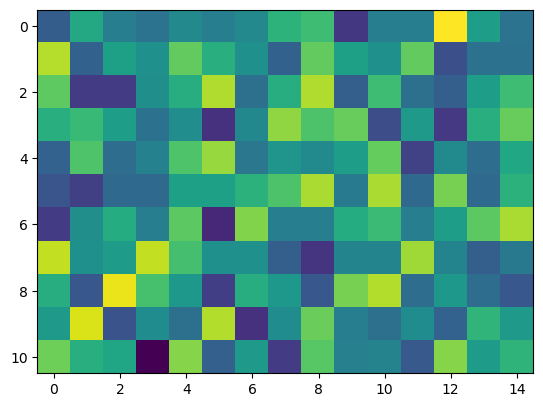

In [495]:
# get profiles from target responses as "groundtruth"
psth_times_tgt = sound_events[sound_events[:, 1] == 2][:, 0]

# TODO: take success ones only?
hw, bc = 0.25, 31

profiles = np.zeros([len(spike_times_HPC), bc - 1])
for i, (unit_id, spk_times) in enumerate(spike_times_HPC.items()):
    bins, counts_tgt = get_spike_counts(spk_times, psth_times_tgt, hw, bc)
    profiles[i] = counts_tgt
    
# z-score
profiles_z = profiles.copy()
for i, prof in enumerate(profiles):
    profiles_z[i] = stats.zscore(prof)
    
# get only unique response part
profile_z_half = profiles_z[:, int((bc-1)/2):]
plt.imshow(profile_z_half)

## Combine background pulses sharing the same state

### Get W4 (spont. act) population dynamics

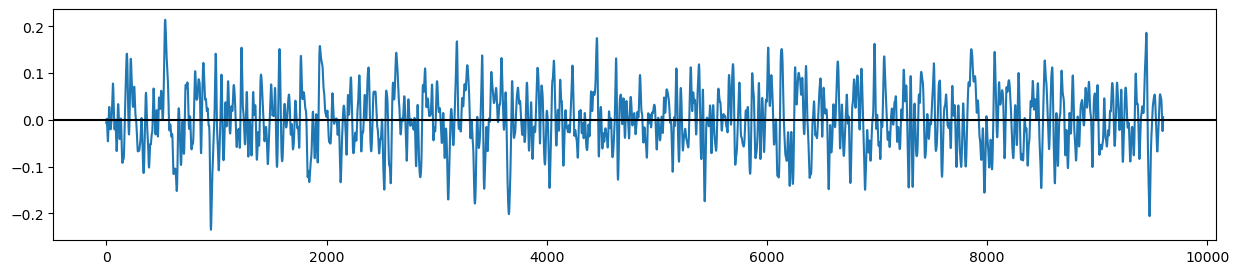

In [496]:
# A1 unit response matrix (not z-scored)
pop_response = spontaneous_activity(os.path.join(dst_path, animal, session))

# TODO: maybe filter slow dynamics
sos = signal.butter(10, 0.01, fs=4, analog=False, btype='highpass', output='sos')
pop_response = signal.sosfiltfilt(sos, pop_response)

fig, ax = plt.subplots(1,1, figsize=(15, 3))
ax.plot(pop_response)
ax.axhline(pop_response.mean(), color='black')

In [497]:
# background and combined
idxs_bgr  = np.where(sound_events[:, 1] == 1)[0]  # idxs to SE
idxs_tgt  = np.where(sound_events[:, 1] == 2)[0]  # idxs to SE
idxs_idle = np.where(tl[sound_events[:, 2].astype(np.int32)][:, 3] < 0.04)[0]  # idxs to SE
idxs_bgr_idle = np.intersect1d(idxs_bgr, idxs_idle)
idxs_tgt_idle = np.intersect1d(idxs_tgt, idxs_idle)
pop_r_filt = pop_response[idxs_bgr_idle]

# split into groups 
group_count = 2
idxs_sort = np.argsort(pop_r_filt)
step = int(np.max(idxs_sort)/group_count)
idxs_grouped = idxs_sort[:group_count*step].reshape(group_count, step)

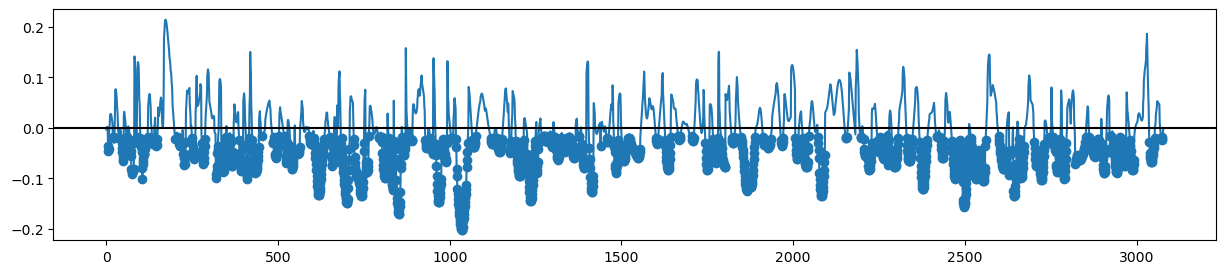

In [498]:
# TODO: W4 mean below 0 after filter idle!
# spont activity is higher when running RESULT

#i_rate = inst_rate(spike_times['3-15'], tl[:, 0], k_width=1000)
#i_rate = i_rate[sound_events[:, 2].astype(np.int32)]
#i_rate = i_rate[idxs_bgr_idle]

fig, ax = plt.subplots(1,1, figsize=(15, 3))
ax.plot(pop_r_filt)
#ax.plot(i_rate*200 + 0.2)
ax.axhline(0, color='black')
ax.scatter(idxs_grouped[0], pop_r_filt[idxs_grouped[0]])

In [499]:
# construct average population response for each "grouped" state

bc_half = int((bc - 1)/2)
unit_mx_by_group = np.zeros([group_count, len(spike_times_HPC), bc_half])

for j, idxs_grp in enumerate(idxs_grouped):
    psth_times = sound_events[idxs_bgr_idle][idxs_grp][:, 0]

    unit_resp = np.zeros([len(spike_times_HPC), bc - 1])
    for i, (unit_id, spk_times) in enumerate(spike_times_HPC.items()):
        bins, counts_grp = get_spike_counts(spk_times, psth_times, hw, bc)
        unit_resp[i] = counts_grp
        
    # z-score
    unit_resp_z = unit_resp.copy()
    for i, prof in enumerate(unit_resp):
        unit_resp_z[i] = stats.zscore(prof)
        
    # get only unique response part
    unit_mx_by_group[j] = unit_resp_z[:, bc_half:]

In [500]:
# all tgt reponses for control
psth_times  = sound_events[idxs_tgt][:, 0]

unit_resp = np.zeros([len(spike_times_HPC), bc - 1])
for i, (unit_id, spk_times) in enumerate(spike_times_HPC.items()):
    bins, counts_grp = get_spike_counts(spk_times, psth_times, hw, bc)
    unit_resp[i] = counts_grp
    
# z-score
unit_resp_z = unit_resp.copy()
for i, prof in enumerate(unit_resp):
    unit_resp_z[i] = stats.zscore(prof)

# get only unique response part
unit_mx_tgt = unit_resp_z[:, bc_half:]

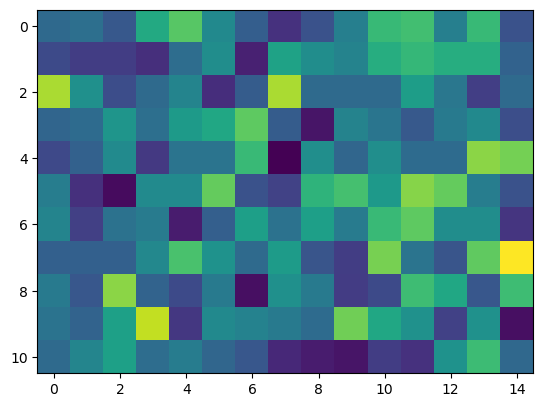

In [501]:
plt.imshow(unit_mx_by_group[1])

In [502]:
# CCR matrix for all units
CCR_mx = np.zeros([group_count, len(spike_times_HPC), bc_half])

for grp_idx in range(group_count):
    for unit_idx in range(len(profile_z_half)):
        prof = profile_z_half[unit_idx]
        spks = unit_mx_by_group[grp_idx][unit_idx]
        #spks = unit_AM_shuf[unit_idx]
        CCR_mx[grp_idx][unit_idx] = signal.correlate(spks, prof, mode='same')

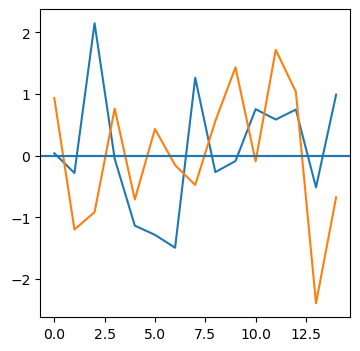

In [503]:
fig = plt.figure(figsize=(4, 4))

ax = fig.add_subplot(111)
for grp_idx in range(group_count):
    #ax = fig.add_subplot(1, group_count, grp_idx+1)
    ax.plot(CCR_mx[grp_idx].mean(axis=0))
    ax.axhline(0)
    #ax.set_ylim(CCR_mx.min(), CCR_mx.max())

In [504]:
CCR_tgt = np.zeros([len(spike_times_HPC), bc_half])
for unit_idx in range(len(profile_z_half)):
    prof = profile_z_half[unit_idx]
    spks = unit_mx_tgt[unit_idx]
    #spks = unit_AM_shuf[unit_idx]
    CCR_tgt[unit_idx] = signal.correlate(spks, prof, mode='same')

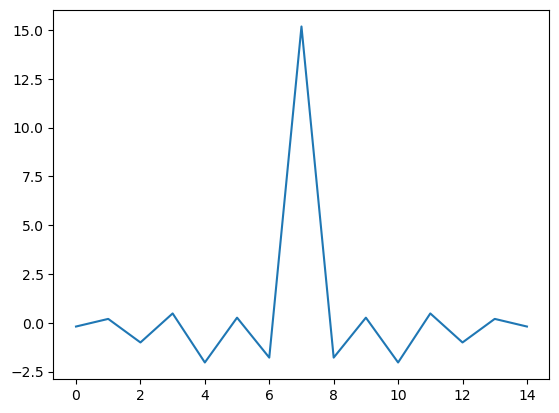

In [505]:
plt.plot(CCR_tgt.mean(axis=0))